In [1]:
%cd ~/user_data/research/git/zero-shot-object-detection/frontend_rpn
%pwd

/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_rpn


/home/DREXEL/jw3897/miniconda3/envs/RegionCLIP/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/DREXEL/jw3897/miniconda3/envs/RegionCLIP/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_rpn'

In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
import cv2
from pycocotools.coco import COCO
from transformers import pipeline
from transformers import Owlv2ImageProcessor, Owlv2Processor, Owlv2ForObjectDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import pandas as pd
import glob

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/home/DREXEL/jw3897/miniconda3/envs/RegionCLIP/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
val_image_dir = r'/mnt/active_storage/Joe/coco_set/val2017/images'
val_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/ovd_ins_val2017_all.json'

coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=val_annotation_path,
)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.config
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

cfg = detectron2.config.get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

#cfg = detectron2.config.CfgNode()
#cfg.merge_from_file(r'./CLIP_fast_rcnn_R_50_C4_ovd_zsinf.yaml')

In [13]:
with open(r'CLIP_fast_rcnn_R_50_C4_ovd_zsinf.yaml', 'r'):
    print()

In [6]:
category_names = ['airplane', 'bus', 'cat', 'dog', 'cow', 'elephant', 'umbrella', \
    'tie', 'snowboard', 'skateboard', 'cup', 'knife', 'cake', 'couch', 'keyboard', \
    'sink', 'scissors']

# Evaluation Code

In [7]:
prediction_files = glob.glob(r'./grouped_predictions/*.parquet')

print(len(prediction_files))

100


In [8]:
score_threshold = 0.0
objectness_threshold = 0.0

In [9]:
predictions_dfs = []

for prediction_file in glob.glob(r'./grouped_predictions/*.parquet'):
    predictions_dfs.append(pd.read_parquet(prediction_file))

predictions_df_total = pd.concat(predictions_dfs)

predictions_df_total.sort_values(by=['image_id'], inplace=True)
predictions_df_total.rename(columns={'label_score': 'score'}, inplace=True)

predictions_df_total = predictions_df_total[(predictions_df_total['objectness_score'] > objectness_threshold) & (predictions_df_total['score'] > score_threshold)]
print(len(predictions_df_total['label'].unique()))

17


In [10]:
display(predictions_df_total)

,image_id,label,score,objectness_score,xmin,ymin,xmax,ymax
3503,139,skateboard,1.134956e-04,4.642580e-04,191.114014,564.022156,356.170593,658.893127
3502,139,sink,1.704169e-05,6.280302e-05,74.447403,606.816650,572.125732,637.531006
3501,139,skateboard,1.012719e-04,3.803953e-04,198.617462,571.477905,320.427002,659.180664
3500,139,couch,1.720663e-04,8.170432e-04,17.593994,603.357056,540.421570,642.475708
3499,139,cat,1.894696e-04,1.001619e-03,96.597481,572.334595,326.284668,657.919189
...,...,...,...,...,...,...,...,...
179979,581781,skateboard,3.255338e-05,1.516650e-04,316.831177,574.082520,503.707916,705.029236
179980,581781,umbrella,1.650790e-07,1.442430e-06,405.394745,605.573242,463.484558,674.013550
179981,581781,airplane,1.283830e-14,3.468864e-06,458.095673,616.307373,533.997131,663.550720
179982,581781,airplane,1.094823e-09,1.371786e-06,434.557007,612.866333,494.262665,666.964722


In [11]:
predictions_dict = predictions_df_total.to_dict('records')

In [12]:
preds = []
pred_boxes = []
pred_scores = []
pred_objectness_scores = []
pred_labels = []

current_img_id = predictions_dict[0]['image_id']
for prediction in predictions_dict:
    # If on a new image...
    if prediction['image_id'] != current_img_id:
        # Convert boxes, scores, and labels to tensors
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
        pred_scores = torch.tensor(pred_scores, dtype=torch.float)
        pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
        pred_labels = torch.tensor(pred_labels, dtype=torch.int)

        # Create the dict for preds
        pred_image_dict = {
            'image_id': current_img_id,
            'boxes': pred_boxes,
            'scores': pred_scores,
            'objectness_scores': pred_objectness_scores,
            'labels': pred_labels
        }

        preds.append(pred_image_dict)

        # Clear boxes, scores, and labels for the new image
        pred_boxes = []
        pred_scores = []
        pred_objectness_scores = []
        pred_labels = []

        # Set new current image id
        current_img_id = prediction['image_id']

    bbox = []
    bbox.append(prediction['xmin'])
    bbox.append(prediction['ymin'])
    bbox.append(prediction['xmax'])
    bbox.append(prediction['ymax'])

    pred_boxes.append(bbox)
    pred_scores.append(prediction['score'])
    pred_objectness_scores.append(prediction['objectness_score'])
    pred_labels.append(category_names.index(prediction['label']))

# Capture the predictions for the last image
pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
pred_scores = torch.tensor(pred_scores, dtype=torch.float)
pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
pred_labels = torch.tensor(pred_labels, dtype=torch.int)

# Create the dict for preds
pred_image_dict = {
    'image_id': current_img_id,
    'boxes': pred_boxes,
    'scores': pred_scores,
    'objectness_scores': pred_objectness_scores,
    'labels': pred_labels
}

preds.append(pred_image_dict)

In [13]:
print(len(preds))

5000


In [14]:
if len(preds) < 5000:
    pred_image_ids = np.unique([pred['image_id'] for pred in preds])
    missing_ids = list(set(image_ids) - set(pred_image_ids.astype(str)))
    for i in range(len(missing_ids)):
        missing_ids[i] = int(missing_ids[i])
    missing_ids.sort()

    for missing_id in missing_ids:
        missing_id = str(missing_id)
        missing_id_dict = {
            'image_id': missing_id,
            'boxes': torch.tensor([], dtype=torch.int),
            'scores': torch.tensor([], dtype=torch.float),
            'objectness_scores': torch.tensor([], dtype=torch.float),
            'labels': torch.tensor([], dtype=torch.int),
        }
        preds.insert(image_ids.index(missing_id), missing_id_dict)

print(len(preds))

5000


In [15]:
category_ids = coco_val_dataset.coco.loadCats(coco_val_dataset.coco.getCatIds())

In [16]:
targets = []
target_boxes = []
target_labels = []

for idx, image_tuple in enumerate(coco_val_dataset):
    image = image_tuple[0]
    annotations = image_tuple[1]
    
    for annotation in annotations:
        label_name = [category['name'] for category in category_ids if category['id'] == annotation['category_id']][0]

        try:
            label = category_names.index(label_name)
        except ValueError as e:
            # If the annotation is not part of the base categories, skip it
            continue

        # xmin, ymin, width, height -> xmin, ymin, xmax, ymax
        box = annotation['bbox']
        bbox = []
        bbox.append(int(round(box[0])))
        bbox.append(int(round(box[1])))
        bbox.append(int(round(box[0] + box[2])))
        bbox.append(int(round(box[1] + box[3])))

        target_boxes.append(bbox)
        target_labels.append(label)

    target_boxes = torch.tensor(target_boxes, dtype=torch.int)
    target_labels = torch.tensor(target_labels, dtype=torch.int)

    target_image_dict = {
        'image_id': image_ids[idx],
        'boxes': target_boxes,
        'labels': target_labels
    }

    targets.append(target_image_dict)

    # Clear boxes and labels
    target_boxes = []
    target_labels = []


In [17]:
labels = []

for target in targets:
    target_labels = target['labels'].detach().tolist()
    for target_label in target_labels:
        labels.append(target_label)

In [18]:
print(len(np.unique(labels)))

17


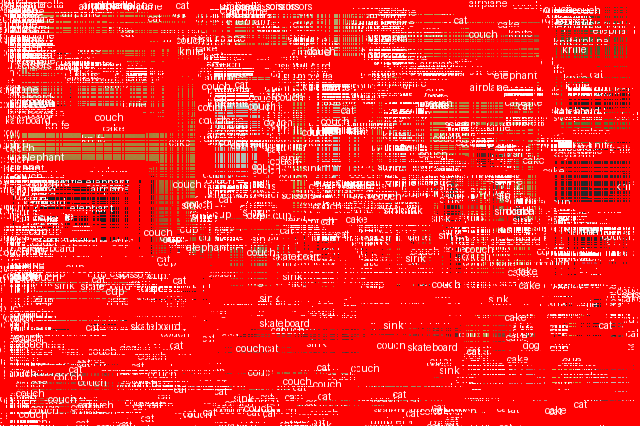

In [19]:
# Visualize some preds and targets
from PIL import ImageDraw

index = 0

visualized_image = coco_val_dataset[index][0].copy()

draw = ImageDraw.Draw(visualized_image)

for box, label in zip(preds[index]['boxes'], preds[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='red')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

for box, label in zip(targets[index]['boxes'], targets[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='green')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

display(visualized_image)

In [20]:
metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_type='bbox',
    iou_thresholds=None, # Defaults to trying from 0.5 -> 0.95 in steps of 0.05 
    rec_thresholds=None,
    max_detection_thresholds=None, # Uses [1, 10, 100]
    class_metrics=False,
    extended_summary=False, # This way, we can see the ious and scores calculated
    average='macro',
    backend='pycocotools'
)

metric.update(preds, targets)

/home/DREXEL/jw3897/miniconda3/envs/owlvit/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


In [21]:
computed_metric = metric.compute()
print(computed_metric)

{'map': tensor(0.5031), 'map_50': tensor(0.7137), 'map_75': tensor(0.5553), 'map_small': tensor(0.2614), 'map_medium': tensor(0.4698), 'map_large': tensor(0.6560), 'mar_1': tensor(0.4199), 'mar_10': tensor(0.6712), 'mar_100': tensor(0.7396), 'mar_small': tensor(0.5130), 'mar_medium': tensor(0.7207), 'mar_large': tensor(0.8478), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}


mAP without any thresholding:

{'map': tensor(0.5031), 'map_50': tensor(0.7137), 'map_75': tensor(0.5553), 'map_small': tensor(0.2614), 'map_medium': tensor(0.4698), 'map_large': tensor(0.6560), 'mar_1': tensor(0.4199), 'mar_10': tensor(0.6712), 'mar_100': tensor(0.7396), 'mar_small': tensor(0.5130), 'mar_medium': tensor(0.7207), 'mar_large': tensor(0.8478), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}

mAP with thresholding objectness_score > 0.1:

{'map': tensor(0.5000), 'map_50': tensor(0.7090), 'map_75': tensor(0.5521), 'map_small': tensor(0.2581), 'map_medium': tensor(0.4676), 'map_large': tensor(0.6524), 'mar_1': tensor(0.4184), 'mar_10': tensor(0.6481), 'mar_100': tensor(0.6834), 'mar_small': tensor(0.4402), 'mar_medium': tensor(0.6569), 'mar_large': tensor(0.8024), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}

mAP with thresholding objectness_score > 0.1 & score > 0.1:

{'map': tensor(0.4974), 'map_50': tensor(0.7052), 'map_75': tensor(0.5493), 'map_small': tensor(0.2573), 'map_medium': tensor(0.4647), 'map_large': tensor(0.6486), 'mar_1': tensor(0.4161), 'mar_10': tensor(0.6319), 'mar_100': tensor(0.6623), 'mar_small': tensor(0.4241), 'mar_medium': tensor(0.6320), 'mar_large': tensor(0.7803), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}